In [1]:
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
%matplotlib inline
import matplotlib.pyplot as plt
mat = loadmat('Data/All_data_bigR.mat') 
mdata = mat['Dataset']  # variable in mat file
mdtype = mdata.dtype

import numpy as np
import pandas as pd

df = pd.DataFrame(mdata,
                  columns = ['moments', 'minmax_scaled', 'minpeaks', 'maxpeaks',
                             'sum_peaks', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40','Z_labels']
                 )
df.loc[df['minpeaks'] >= 3, 'minpeaks'] = 3
df.loc[df['maxpeaks'] >= 3, 'maxpeaks'] = 3

In [2]:
#split-shuffle data train-test
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["Z_labels"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]
dropped_labels = ["Z_labels", "sum_peaks"] #drop sum_peaks because it is linearly collinear with minpeaks/maxpeaks
#already extract the test data - but first treat the training to remove outliers
X_test = strat_test_set.drop(dropped_labels, axis=1)
Y_test = strat_test_set["Z_labels"].copy()
train_X = strat_train_set.drop(dropped_labels, axis=1)#df_train_new.drop(dropped_labels, axis=1)
Y_train = strat_train_set["Z_labels"].copy()#df_train_new["Z_labels"].copy()



In [3]:
#training model 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
    
num_attribs = ['moments', 'minmax_scaled', 'r_minmax', 'r1','r2','r3',
                             'r4', 'r5', 'r6', 'r7', 'r8', 'r9',
                             'r10', 'r11', 'r12','r13', 'r14', 'r15',
                             'r16', 'r17', 'r18', 'r19', 'r20', 'r21',
                             'r22', 'r23', 'r24', 'r25', 'r26', 'r27','r28','r29',
                             'r30','r31','r32','r33','r34','r35','r36','r37','r38',
                             'r39','r40']

cat_attribs = ['minpeaks','maxpeaks']

num_pipeline = Pipeline([
            ('Factor_Analysis', FactorAnalyzer(n_factors=5, rotation="varimax")),
            ('std_scaler', StandardScaler())    
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs), #call the num_pipeline defined above on numerical attribs
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs), #call OneHotEncoder on categorical attribs
])

train_X_final = full_pipeline.fit_transform(train_X)


In [6]:
#fitting data
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_X_final, Y_train)

LinearRegression()

In [7]:
#transforming test data with pipeline on train
X_test_final = full_pipeline.transform(X_test)

Residuals without removing outliers (labelling): 2.0328808415645288 
 Residuals with outliers removed: 1.966711217398944
num outliers: 20, % outliers: 0.0025490695895997962


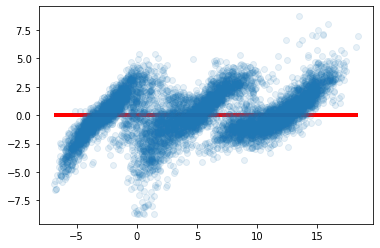

In [9]:
from sklearn.metrics import mean_squared_error
def Tukey_IQR(array, low=25, high=75, kval=1.5):
    import numpy as np
    LQR = np.percentile(array, low)
    UQR = np.percentile(array, high)
    IQR = UQR-LQR
    return LQR - kval*IQR, UQR + kval*IQR

def Tukey_outlier_detection(array, low=25, high=75, kval=3):
    L, H = Tukey_IQR(array, low, high, kval)
    return np.where((array < L) | (array > H))[0]

# final_predictions = lin_reg.predict(X_test_final)
final_predictions = model.predict(X_test_final)
residuals = Y_test.to_numpy()-final_predictions

outliers = Tukey_outlier_detection(residuals,kval=3) #due to poor labelling
Y_test_no_outliers = np.delete(Y_test.to_numpy(),(outliers))
residuals_no_outliers = np.delete(residuals,(outliers))
final_preds_no_outliers = np.delete(final_predictions,(outliers))

# plt.plot(Y_test,residuals,'o', alpha=0.1)
plt.plot(Y_test_no_outliers,residuals_no_outliers,'o', alpha=0.1)
plt.hlines(0,min(Y_test),max(Y_test),color='r',linewidth=4)
print(f"Residuals without removing outliers (labelling): {np.sqrt(mean_squared_error(Y_test, final_predictions))} \n Residuals with outliers removed: {np.sqrt(mean_squared_error(Y_test_no_outliers, final_preds_no_outliers))}")
print(f"num outliers: {len(outliers)}, % outliers: {len(outliers)/len(strat_test_set)}")

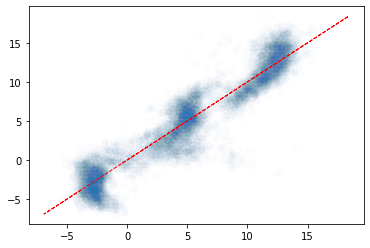

In [7]:
plt.plot(final_predictions,Y_test,'o', alpha=0.01)
plt.plot(Y_test,Y_test,'r--', linewidth=1)

(array([ 9.,  0.,  0.,  0., 11., 47., 29.,  5.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  2.,  5.,  6.,  3.,  3.]),
 array([-6.9  , -5.635, -4.37 , -3.105, -1.84 , -0.575,  0.69 ,  1.955,
         3.22 ,  4.485,  5.75 ,  7.015,  8.28 ,  9.545, 10.81 , 12.075,
        13.34 , 14.605, 15.87 , 17.135, 18.4  ]),
 <BarContainer object of 20 artists>)

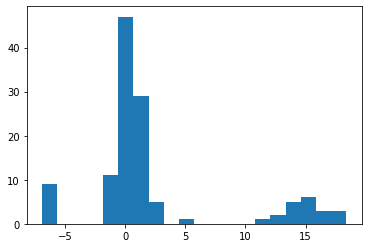

In [33]:
plt.hist(Y_test.to_numpy()[outliers],bins=20)

In [8]:
#save model
import joblib
joblib.dump(lin_reg, "linear_model_final.pkl")

['linear_model_final.pkl']

In [1]:
import joblib
model = joblib.load("linear_model_final.pkl")